In [1]:
from IPython.core.debugger import Tracer
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models
import argparse
from datetime import datetime
import os
import time
import multiprocessing
import psutil
import json
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd  
import h5py
from sklearn.model_selection import train_test_split
from skimage.util import crop,  random_noise
from skimage.transform import   rescale, resize, rotate, AffineTransform, warp
import torch.optim as optim
from tqdm import tqdm
import copy
from collections import Counter
from PIL import Image
from pathlib import Path
import warnings
from monai.utils import ensure_tuple, optional_import
from IPython.core.debugger import Tracer
from copy import deepcopy
from monai.transforms.compose import Transform
from monai.transforms import \
    Compose, LoadPNG, AddChannel, ScaleIntensity, ToTensor, RandRotate, RandFlip, RandZoom
from monai.metrics import compute_roc_auc, compute_occlusion_sensitivity
from collections.abc import Sequence
from functools import partial
from typing import Dict, List, Optional, Sequence, Union

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import seaborn as sns
import random

In [2]:
data_dir = 'data/CellCycle'
class_names = sorted([x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x))])
num_class = len(class_names)
all_files = [[os.path.join(data_dir, class_name, x) 
                for x in os.listdir(os.path.join(data_dir, class_name))] 
               for class_name in class_names]
image_files = [list(set([os.path.join(data_dir, class_name, x.split("_")[0]) 
                for x in os.listdir(os.path.join(data_dir, class_name))])) 
               for class_name in class_names]
image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))
num_total = len(image_label_list)
image_width, image_height = Image.open(all_files[0][0]).size

print('Total image count:', num_total)
print("Image dimensions:", image_width, "x", image_height)
print("Label names:", class_names)
print("Label counts:", [len(image_files[i]) for i in range(num_class)])

Total image count: 32266
Image dimensions: 66 x 66
Label names: ['Anaphase', 'G1', 'G2', 'Metaphase', 'Prophase', 'S', 'Telophase']
Label counts: [15, 14333, 8601, 68, 606, 8616, 27]


In [3]:
flat_list = [item for sublist in all_files for item in sublist]

x = []
y = []
for i in flat_list:
    im = Image.open(i)
    Tracer()()
    width, height = im.size
    x.append(width)
    y.append(height)
    if width != 66 or height != 66:
        print(i)
plt.scatter(x, y)
plt.show()

In [4]:
valid_frac, test_frac = 0.1, 0.1
trainX, trainY = [], []
valX, valY = [], []
testX, testY = [], []

for i in range(num_total):
    rann = np.random.random()
    if rann < valid_frac:
        valX.append(image_file_list[i])
        valY.append(image_label_list[i])
    elif rann < test_frac + valid_frac:
        testX.append(image_file_list[i])
        testY.append(image_label_list[i])
    else:
        trainX.append(image_file_list[i])
        trainY.append(image_label_list[i])

print("Training count =",len(trainX),"Validation count =", len(valX), "Test count =",len(testX))

Training count = 25762 Validation count = 3245 Test count = 3259


In [5]:
class LoadImage(Transform):
    """
    Load common 2D image format (PNG, JPG, etc. using PIL) file or files from provided path.
    If loading a list of files, stack them together and add a new dimension as first dimension,
    and use the meta data of the first image to represent the stacked result.
    It's based on the Image module in PIL library:
    https://pillow.readthedocs.io/en/stable/reference/Image.html
    """

    def __init__(self, only_channels = []) -> None:
        self.only_channels = only_channels

    def __call__(self, name: Union[Sequence[Union[Path, str]], Path, str]):
        img_array = list()
        class_dir = os.path.dirname(name)
        sample_id = os.path.basename(name) + "_Ch"
        channels = [np.asarray(Image.open(os.path.join(class_dir, file)))/255. for file in os.listdir(class_dir) if file.startswith(sample_id)]
        #Tracer()()
        image = np.stack(channels, axis = 2)
        image_RGB = image*255
        return Image.fromarray(np.uint8(image_RGB))
        #img_array.append(image)
        #img_array = np.stack(img_array, axis=0) if len(img_array) > 1 else img_array[0]
        #return image

In [6]:
class ToTensorCustom(Transform):
    """
    Converts the input image to a tensor without applying any other transformations.
    """

    def __call__(self, img: Union[np.ndarray, torch.Tensor]) -> torch.Tensor:
        """
        Apply the transform to `img` and make it contiguous.
        """
        #img = np.asarray(img)
        #image = torch.from_numpy(copy.deepcopy(img))
        if torch.is_tensor(img):
            return img.contiguous().T
        return torch.as_tensor(np.ascontiguousarray(img) / 255.).T

In [7]:
train_transforms = transforms.Compose([
    LoadImage(),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    ToTensorCustom()
])
val_transforms = transforms.Compose([
    LoadImage(),
    ToTensorCustom()
])

In [8]:
class JurkatDataset(Dataset):

    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

train_ds = JurkatDataset(trainX, trainY, train_transforms)
train_loader = DataLoader(train_ds, batch_size=300, shuffle=True, num_workers=10)

val_ds = JurkatDataset(valX, valY, val_transforms)
val_loader = DataLoader(val_ds, batch_size=300, num_workers=10)

test_ds = JurkatDataset(testX, testY, val_transforms)
test_loader = DataLoader(test_ds, batch_size=300, num_workers=10)

In [9]:
def plot_heatmap_3_channels(heatmap):
    fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15,15))
    #plt.figure(figsize=(20,10))
    ax1.imshow(heatmap[0])
    ax2.imshow(heatmap[1])
    ax3.imshow(heatmap[2])

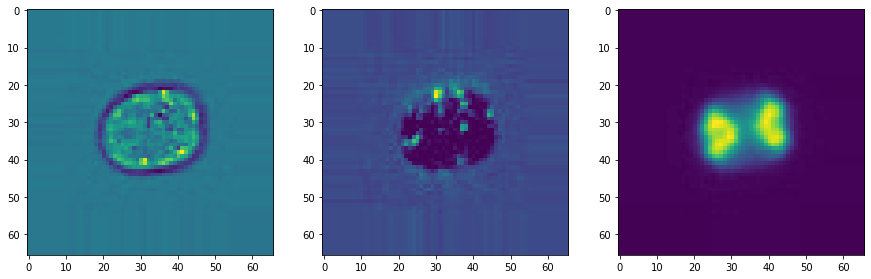

In [10]:
plot_heatmap_3_channels(test_ds[0][0])

In [11]:
resnet18 = models.resnet18(pretrained=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# change first layer
#model_ft.conv1 = torch.nn.Conv2d(64, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_ftrs = resnet18.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
resnet18.fc = nn.Linear(num_ftrs, num_class)

resnet18 = resnet18.to(device)

loss_function = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(resnet18.parameters(), 1e-5)
#optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)
 
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
epoch_num = 10
val_interval = 1
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
for epoch in range(epoch_num):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    resnet18.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device).float(), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = resnet18(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        resnet18.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device).float(), val_data[1].to(device)
                y_pred = torch.cat([y_pred, resnet18(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            #Tracer()()
            auc_metric = compute_roc_auc(y_pred, y, to_onehot_y=True, softmax=True)
            metric_values.append(auc_metric)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if auc_metric > best_metric:
                best_metric = auc_metric
                best_metric_epoch = epoch + 1
                torch.save(resnet18.state_dict(), 'best_metric_model_adam.pth')
                print('saved new best metric model')
            print(f"current epoch: {epoch + 1} current AUC: {auc_metric:.4f}"
                  f" current accuracy: {acc_metric:.4f} best AUC: {best_metric:.4f}"
                  f" at epoch: {best_metric_epoch}")
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

----------
epoch 1/10
1/85, train_loss: 2.7576
2/85, train_loss: 2.7025
3/85, train_loss: 2.7475
4/85, train_loss: 2.6777
5/85, train_loss: 2.6501
6/85, train_loss: 2.6442
7/85, train_loss: 2.5984
8/85, train_loss: 2.5472
9/85, train_loss: 2.6146
10/85, train_loss: 2.5773
11/85, train_loss: 2.5684
12/85, train_loss: 2.5238
13/85, train_loss: 2.4863
14/85, train_loss: 2.4260
15/85, train_loss: 2.4660
16/85, train_loss: 2.4550
17/85, train_loss: 2.3739
18/85, train_loss: 2.3547
19/85, train_loss: 2.3941
20/85, train_loss: 2.4002
21/85, train_loss: 2.3066
22/85, train_loss: 2.3028
23/85, train_loss: 2.2953
24/85, train_loss: 2.3098
25/85, train_loss: 2.2753
26/85, train_loss: 2.2612
27/85, train_loss: 2.2225
28/85, train_loss: 2.1366
29/85, train_loss: 2.2020
30/85, train_loss: 2.0833
31/85, train_loss: 2.1534
32/85, train_loss: 2.1132
33/85, train_loss: 2.0976
34/85, train_loss: 2.0320
35/85, train_loss: 2.0666
36/85, train_loss: 2.0351
37/85, train_loss: 2.0044
38/85, train_loss: 1.9874